### Kernel method et soft Support Vector Machine par Descente de Gradient Stochastique

Voir chapitre 16 du livre Understanding Machine Learning de S. Shalev-Shwartz et S. Ben-David

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def hinge_loss(x):
    return max(0,1-x)

In [73]:
def kernel(x,xprime):
    k=20
    sigma=0.5
    return (1+np.dot(x,xprime))**k
    #return np.exp(-np.dot(x-xprime,x-xprime)/2/sigma)

In [74]:
class Hyperplan:
    m=100
    def __init__(self,alpha=np.zeros(1),b=0):
        if self.m>=len(alpha):
            self.alpha=np.concatenate((alpha,np.zeros(self.m-len(alpha))))
        else:
            self.alpha=alpha[0:self.m]
        self.b=b
        
    def __repr__(self):
        return f"{self.__class__.__name__}({self.alpha,self.b})"
    
    def __call__(self,x,x_train):
        return sum([self.alpha[i]*kernel(xi,x) for i,xi in enumerate(x_train)])+self.b
        
    def loss(self,x,y,x_train):
        return hinge_loss(y*self(x,x_train))
    
    def square(self,K):
        return np.dot(self.alpha,np.dot(K,self.alpha))+self.b**2
    
    def risk(self,x,y,K,lambd,x_train):
        return lambd/2*self.square(K)+1/len(y)*sum([self.loss(xi,y[i],x_train) for i,xi in enumerate(x)])
    
    def risk_vrai(self,x,y,x_train):
        return sum([np.sign(self(xx,x_train))!=y[i] for i,xx in enumerate(x)])/len(x)
    
    def gradient_loss(self,y,K,i):
        if y*(np.dot(K,self.alpha)+self.b)<1:
            v1=-y
            v2=-y
        else:
            v1=0
            v2=0
        return v1,v2
    
    def SGD(self,x,y,K,lambd,niter=1000,learning=0.1):
        w=Hyperplan(self.alpha,self.b)
        liste=[w]
        for i in range(niter):
            it=np.random.randint(len(x))
            v1t,v2t=self.gradient_loss(y[it],K[it,:],it)
            self.alpha=(1-learning/(i+1)*lambd)*self.alpha
            self.b=(1-learning/(i+1)*lambd)*self.b
            self.alpha[it]=self.alpha[it]-learning/(i+1)*v1t
            self.b=self.b-learning/(i+1)*v2t
            w=Hyperplan(self.alpha,self.b)
            liste.append(w)
        return self,liste    

In [75]:
class Polynomial:
    def __init__(self, weights=[0]):
        self.weights = np.array(weights)
        d=np.shape(weights)[0]
        self.void = np.zeros([d,d])
        for i in range(d):
            for j in range(d-i):
                self.void[i,j]=1
        self.weights=self.weights*self.void

    def __repr__(self):
        return f"{self.__class__.__name__}({self.weights})"
    
    @property
    def degree(self):
        return np.shape(self.weights)[0]-1
    
    def __call__(self, x):
        X1=np.transpose(np.array([[x[0]**exp for exp in range(self.degree+1)]]))
        X2=np.array([[x[1]**exp for exp in range(self.degree+1)]])
        return np.dot(X2,np.dot(self.weights,X1))[0,0]

In [76]:
def affiche(x,y,h,x_train):
    m=len(x)
    yresult=[]
    for i in range(m):
        yresult.append(np.sign(h(x[i],x_train)))

    plt.figure(1)
    plt.rcParams["figure.figsize"] = [20,10]
    fig,axs=plt.subplots(1,2)

    for i in range(m):
        if y[i]==-1:
            axs[0].plot(x[i][0],x[i][1],'Xb')
        if y[i]==1:
            axs[0].plot(x[i][0],x[i][1],'or')
    axs[0].set_title('Données de référence',fontsize=14)
    for i in range(m):
        if yresult[i]==-1:
            axs[1].plot(x[i][0],x[i][1],'Xb')
        else:
            axs[1].plot(x[i][0],x[i][1],'or')

In [77]:
def affiche_risques(liste,x,y,K,lambd,x_train,label):
    if label==0:
        risque=[]
        for i in range(len(liste)):
            risque.append(liste[i].risk(x,y,K,lambd,x_train))
        plt.plot(risque)
    else:
        risque_vrai=[]
        for i in range(len(liste)):
            risque_vrai.append(liste[i].risk_vrai(x,y,x_train))
        plt.plot(risque_vrai)    

In [78]:
# Les paramètres :
# dimension de l'espace des x
d=2

# degré du polynôme de départ
deg=5

# on introduit ce petit pourcentage d'erreurs dans les données
seuil_erreur=0.

# taille de l'échantillon de données d'entraînement
m=200
Hyperplan.m=m

# taille de l'échantillon de données de test 
mtest=1000

# bornes sur l'espace des données x
xmax=1.25
xmin=-1.25

# valeur de lambda pour le soft-SVM
lambd=1

# valeur du taux d'apprentissage initialement pour le soft-SVM
learning=0.1

In [79]:
# fabrication des données

w=2*np.random.rand(deg+1,deg+1)-1
w[0,0]=0
pf=Polynomial(w)
x=[]
y=[]
for i in range(m):
    x.append((xmax-xmin)*np.random.rand(d)+xmin)
    if np.random.rand()>seuil_erreur:
        y.append(np.sign(pf(x[i])))
    else:
        y.append(-np.sign(pf(x[i])))
xtest=[]
ytest=[]
for i in range(mtest):
    xtest.append((xmax-xmin)*np.random.rand(d)+xmin)
    ytest.append(np.sign(pf(xtest[i])))
    
K=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        K[i,j]=kernel(x[i],x[j])

In [80]:
# Résolution du problème soft-SVM
h=Hyperplan()
h,liste=h.SGD(x,y,K,lambd,10000,learning=1)

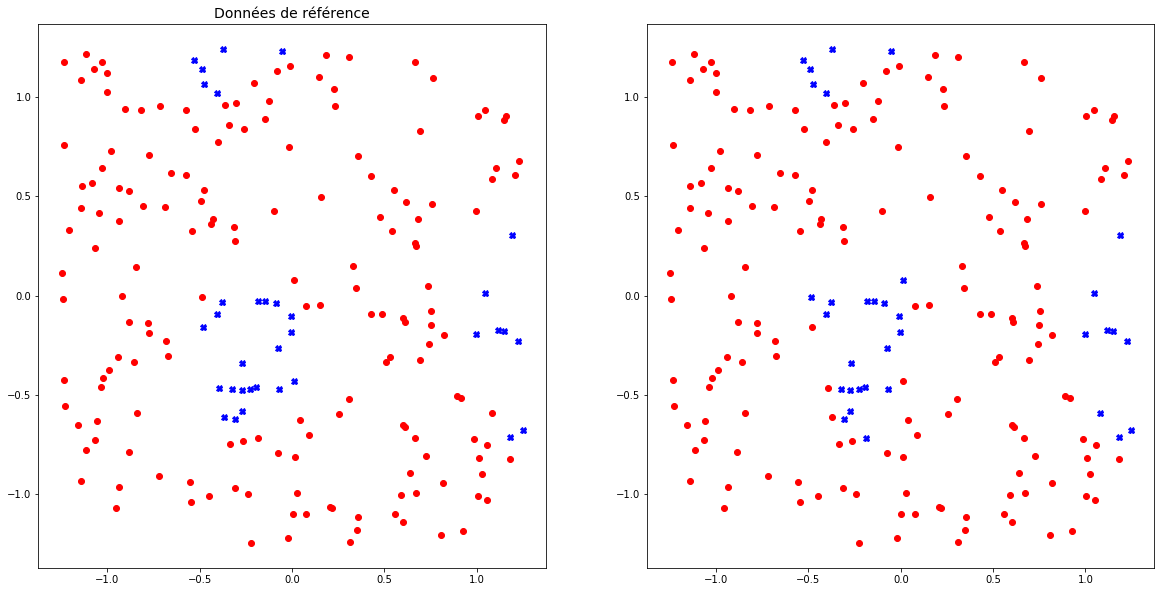

In [81]:
affiche(x,y,h,x)

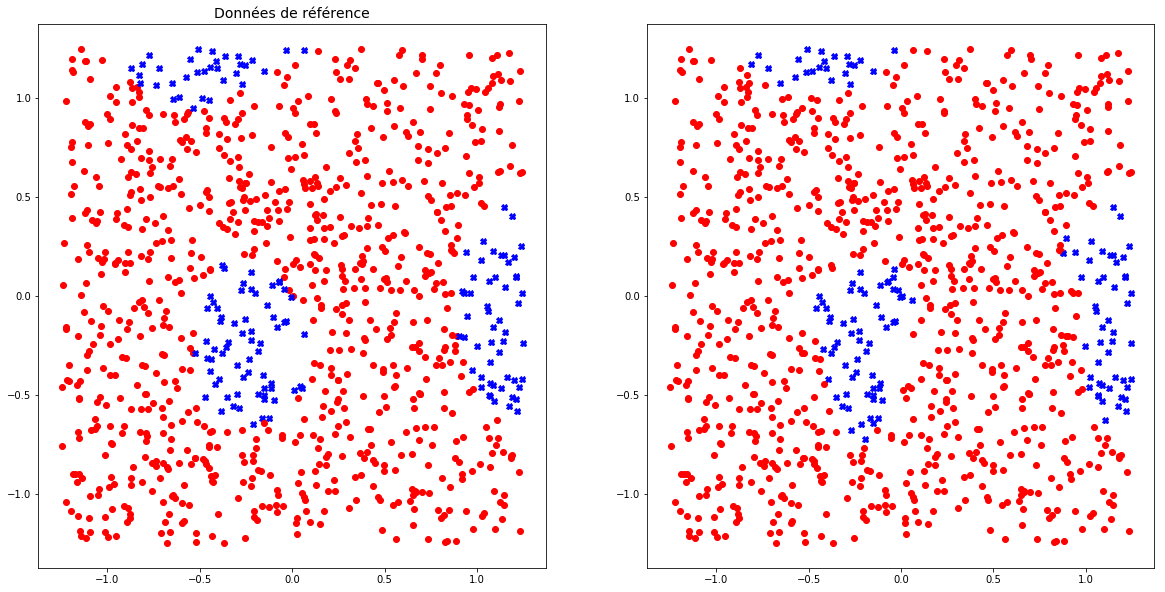

In [82]:
affiche(xtest,ytest,h,x)

In [732]:
fichier = open("data_banknote_authentication.txt", "r")
databrute=fichier.read().splitlines()
print("Nombre de données : ", np.shape(databrute)[0])
taille=np.shape(databrute)[0]
data=np.zeros((taille,5))
for i in range(taille):
    data[i,:]=databrute[i].split(',')
data[:,0]=data[:,0]/max(np.abs(data[:,0]))
data[:,1]=data[:,1]/max(np.abs(data[:,1]))
data[:,2]=data[:,2]/max(np.abs(data[:,2]))
data[:,3]=data[:,3]/max(np.abs(data[:,3]))

Nombre de données :  1372


In [733]:
taille_training=int(taille*0.8)
taille_test=taille-taille_training
indice=np.random.permutation(taille)
training=data[indice[0:taille_training]]
test=data[indice[taille_training:taille]]
x=[]
y=[]
for i in range(np.shape(training)[0]):
        x.append(training[i,0:4])
        y.append(2*training[i,4]-1)
xtest=[]
ytest=[]
for i in range(np.shape(test)[0]):
        xtest.append(test[i,0:4])
        ytest.append(2*test[i,4]-1)
d=4
m=taille_training
Hyperplan.m=m

In [734]:
K=np.zeros((m,m))
for i in range(m):
    for j in range(m):
        K[i,j]=kernel(x[i],x[j])

In [737]:
# Résolution du problème soft-SVM
h=Hyperplan()
h,liste=h.SGD(x,y,K,lambd,100000,learning=1)

In [738]:
print('erreur d\'entraînement :',100*(1-h.risk_vrai(x,y,x)))
print('erreur sur les valeurs test :',100*(1-h.risk_vrai(xtest,ytest,x)))

erreur d'entraînement : 98.81494986326345
erreur sur les valeurs test : 99.27272727272727
